### 0. Importing Libraries and Files

In [88]:
import pandas as pd
import geopandas as geo_pd
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
import csv
import ast
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, validation_curve, cross_validate, cross_val_score
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from scipy.stats import randint
import xgboost as xgb

def read_data(path):
    data = pd.read_csv(path, skipinitialspace=True)
    return data

# Part A
location_data = read_data('./all_data/partA/data/location_2021.csv')
train_cases = read_data('./all_data/partA/data/cases_2021_train.csv')
world_data = geo_pd.read_file('./world_map_data/ne_110m_admin_0_countries.shp')
# Part B
processed_train_cases = read_data('./all_data/partB/data/cases_2021_train_processed_2.csv')
processed_test_cases = read_data('./all_data/partB/data/cases_2021_test_processed_unlabelled_2.csv')
    

## 1. Data Visualization

#### Data Reading and Cleaning

In [89]:
def clean_cases(cases : pd.DataFrame):
    ''' Various values found from train cases
    'Hospitalized' 'Recovered' 'Deceased' 'Discharged' 'Alive' 'Discharge'
    'Under treatment' 'Stable' 'Died' 'Receiving treatment' 'Death'
    'Stable condition' 'Dead' 'Discharged from hospital' 'Critical condition'
    'Released from quarantine' 'Recovering at home 03.03.2020'
    '''
    hospitalized = ['Hospitalized', 'Discharged', 'Discharge', 'Under treatment', 
                    'Receiving treatment', 'Discharged from hospital', 'Critical condition']
    non_hospitalized = ['Alive', 'Stable', 'Stable condition', 'Released from quarantine', 
                        'Recovering at home 03.03.2020', 'Recovered']
    deceased = ['Deceased', 'Died', 'Death', 'Dead']
    
    cases.loc['outcome'] = cases['outcome'].str.capitalize()
    cases.loc[cases['outcome'].isin(hospitalized), 'outcome'] = 'Hospitalized'
    cases.loc[cases['outcome'].isin(non_hospitalized), 'outcome'] = 'Non-Hospitalized'
    cases.loc[cases['outcome'].isin(deceased), 'outcome'] = 'Deceased'
    # Handle cases where there is more cases than what is known. Can't use 'Other' due to project req.
    cases.loc[~cases['outcome'].isin(['Hospitalized', 'Non-Hospitalized', 'Deceased']), 'outcome'] = 'Non-Hospitalized'
    return

def clean_dataset(location_data: pd.DataFrame, train_cases: pd.DataFrame):
    location_data = location_data[['Country_Region', 'Confirmed', 'Deaths', 'Province_State']]
    # age,sex,province,country,latitude,longitude,date_confirmation,additional_information,source,chronic_disease_binary
    train_cases = train_cases[['age', 'sex', 'country', 'province', 'chronic_disease_binary', 'outcome', 'outcome_group']]
    # standardize naming convention
    clean_cases(train_cases)
    location_data = location_data.rename(columns={'Country_Region': 'country', 'Province_State': 'province'}) 
    location_data.loc[location_data['country'] == 'US', 'country'] = 'United States'
    
    # Fix missing data
    location_data['province'] = location_data['province'].fillna(location_data['country'])

    return train_cases, location_data

# Colour Palette with Indices for Seaborn
# Reference: https://stackoverflow.com/questions/36271302/changing-color-scale-in-seaborn-bar-plot
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return list(np.array(palette).take(indices, axis=0))


#### Data Plotting

In [90]:
def plot_data(df: pd.DataFrame, world: geo_pd.GeoDataFrame):
    total_available_data = df['count'].sum()
    
    merged_world = pd.merge(world, df, left_on=['NAME_CIAWF'], right_on=['country'], how='left')
    
    # Percentage is based on avaliable data of country / total avaliable data from all countries
    merged_world['available_percentage'] = (merged_world['count'] / total_available_data) * 100   
    merged_world['available_percentage_log'] = np.log(merged_world['available_percentage'])  
      
    # Plot Heat Map
    _, ax = plt.subplots(1, 1)
    merged_world.plot(column='available_percentage', ax=ax, cmap="rocket_r", 
                      legend=True, legend_kwds={'shrink': 0.6}, vmax=100, vmin=0) # Only used for proper Legend values
    merged_world.plot(column='available_percentage_log', ax=ax, cmap="rocket_r", legend=False) # Using Log for bigger differences
    ax.tick_params(left = False, labelleft = False, bottom = False, labelbottom = False)
    
    # # Plot Bar Plot
    by_continent = merged_world.groupby('CONTINENT').sum('count').reset_index()
    by_continent.loc[by_continent['CONTINENT'] == 'Seven seas (open ocean)', 'CONTINENT'] = 'Seven seas'
    by_continent['log_count'] = np.log(by_continent['count'].replace(0.0, np.nan))
    by_continent.fillna(0, inplace=True)

    y_values_log = by_continent['log_count'].values.tolist()
    
    _, ax1 = plt.subplots(1, 1)
    ax1 = sns.barplot(by_continent, x = 'CONTINENT', y = 'log_count', 
                      palette = colors_from_values(np.array(y_values_log), "YlOrRd"), hue = 'CONTINENT', legend = False)
    ax1.set(xlabel='Continents', ylabel='Available Data')
    
    # Add value to the bars
    for p in ax1.patches:
        # Revert the log to use correct numbers when showcasing values
        value = np.round(np.exp(p.get_height()), decimals=0).astype(int) if p.get_height() > 0 else 0
        ax1.annotate(value,
                    xy = (p.get_x()+p.get_width()/2., p.get_height()),
                    ha = 'center',
                    va = 'center',
                    xytext = (0, 10),
                    textcoords = 'offset points')


    plt.tick_params(left = False, labelleft = False)
    plt.xticks(rotation = 45)
    plt.show()

#### Driver Code

C:\Users\pewpe\AppData\Local\Temp\ipykernel_78132\832819255.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cases.loc['outcome'] = cases['outcome'].str.capitalize()


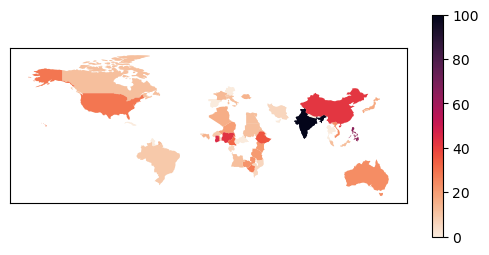

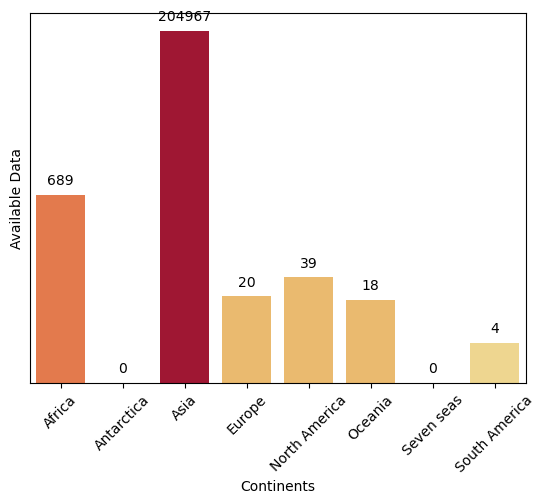

In [91]:
train_data, location_data = clean_dataset(location_data, train_cases)

# Merge data set
merged_data = pd.concat([train_cases, location_data], ignore_index = True)    # concat on country
num_avaliable_data_by_country = merged_data[merged_data['outcome'].notna()] \
                                .value_counts('country').reset_index()
# Plot
plot_data(num_avaliable_data_by_country, world_data)

## 2. Data Pre-processing

#### Preprocessing

In [92]:
# Merge data
merged_data = pd.merge(train_cases, location_data, how='left', on=['country', 'province'])
merged_data = merged_data.dropna(subset = merged_data.columns.difference(['outcome_group']))
# Add Expected Mortality Rate
# Observed deaths in cases_2021_train (based on location) / Location (country, province) Deaths count
observed_deaths_data = merged_data[merged_data['outcome'] == 'Deceased']    \
                        .value_counts(['country', 'province', 'outcome']).reset_index()  \
                        .rename(columns={"count": "observed_deaths"}).drop('outcome', axis=1)
merged_data = pd.merge(merged_data, observed_deaths_data, how='left', on=['country', 'province']) 
merged_data['Expected_Mortality_Rate'] = merged_data['observed_deaths'] / merged_data['Deaths']

#### Driver Code

In [93]:
merged_data


,age,sex,province,country,latitude,longitude,date_confirmation,additional_information,source,chronic_disease_binary,outcome,outcome_group,Confirmed,Deaths,observed_deaths,Expected_Mortality_Rate
0,26,male,Bihar,India,26.221520,84.358790,07.04.2020,"Same family,",https://twitter.com/sanjayjavin/status/1247571...,False,Hospitalized,NaN,265527.0,1576.0,3.0,0.001904
1,42,female,Queensland,Australia,-28.016700,153.400000,30.01.2020,QLD Case 2 quarantine at the Gold Coast Univer...,https://www.health.qld.gov.au/news-events/doh-...,False,discharge,NaN,1477.0,6.0,NaN,NaN
2,30,male,Karnataka,India,12.867673,75.251507,26.05.2020,International Travel from Qatar,https://twitter.com/DHFWKA/status/126518463555...,False,Hospitalized,NaN,997004.0,12567.0,23.0,0.001830
3,4,male,Karnataka,India,13.335010,74.749360,21.05.2020,"Travelled from Mumbai, Maharashtra",https://twitter.com/DHFWKA/status/126337507668...,False,Hospitalized,NaN,997004.0,12567.0,23.0,0.001830
4,50,male,Karnataka,India,12.867673,75.251507,28.05.2020,Returnee from\r\nMaharashtra,https://t.me/Karnataka_KoViD19_Broadcast/3670,False,Hospitalized,NaN,997004.0,12567.0,23.0,0.001830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3891,21,male,Karnataka,India,17.900000,77.550000,31.05.2020,Travelled from Maharashtra,https://twitter.com/DHFWKA/status/126707739902...,False,Hospitalized,NaN,997004.0,12567.0,23.0,0.001830
3892,25,female,Karnataka,India,16.200000,77.366670,31.05.2020,Travelled from Maharashtra,https://twitter.com/DHFWKA/status/126707739902...,False,Hospitalized,NaN,997004.0,12567.0,23.0,0.001830
3893,28,male,Karnataka,India,15.433120,75.635450,14.05.2020,"Travelled from Ahmedabad, Gujarat",https://twitter.com/DHFWKA/status/126082976107...,False,Hospitalized,NaN,997004.0,12567.0,23.0,0.001830
3894,38,male,Shaanxi,China,34.955530,109.858500,03.02.2020,son-in-law of another patient,http://sxwjw.shaanxi.gov.cn/art/2020/2/3/art_9...,False,stable,NaN,567.0,3.0,NaN,NaN


## 3. Feature Selection

#### Feature Removing

In [94]:
test_cases = processed_test_cases
train_cases = processed_train_cases

# Combine Country and Province and remove their individual columns
train_cases['combined_key'] = train_cases['country'] + ', ' + train_cases['province']
test_cases['combined_key'] = test_cases['country'] + ', ' + test_cases['province']
train_cases.drop('country', axis=1, inplace=True)
test_cases.drop('country', axis=1, inplace=True)
train_cases.drop('province', axis=1, inplace=True)
test_cases.drop('province', axis=1, inplace=True)

# These features do not seem to impact the performance
train_cases.drop('Confirmed', axis=1, inplace=True)
test_cases.drop('Confirmed', axis=1, inplace=True)
train_cases.drop('Active', axis=1, inplace=True)
test_cases.drop('Active', axis=1, inplace=True)
train_cases.drop('Incident_Rate', axis=1, inplace=True)
test_cases.drop('Incident_Rate', axis=1, inplace=True)
train_cases.drop('Recovered', axis=1, inplace=True)
test_cases.drop('Recovered', axis=1, inplace=True)
train_cases.drop('Deaths', axis=1, inplace=True)
test_cases.drop('Deaths', axis=1, inplace=True)

#### Driver Code

In [95]:
print(train_cases.head(10))
print(test_cases.head(10))


   age     sex   latitude   longitude date_confirmation  \
0   18  female  25.490960   85.939030        2020-05-18   
1   27  female   7.070000  125.600000        2020-04-15   
2   46    male  13.083620   80.282520        2020-05-02   
3   21  female  13.083620   80.282520        2020-05-24   
4   27    male  26.283610   87.203470        2020-05-27   
5   24    male  24.457120   85.137490        2020-05-26   
6   65  female  19.420820   76.050130        2020-04-03   
7   35    male  25.473982   84.536523        2020-04-29   
8   22    male  19.387650   85.050120        2020-05-02   
9   36  female  20.189990   86.304550        2020-04-30   

   chronic_disease_binary  Case_Fatality_Ratio    outcome_group  \
0                   False             0.593537     hospitalized   
1                   False             1.779368  nonhospitalized   
2                   False             1.434463     hospitalized   
3                   False             1.434463     hospitalized   
4              

## 4. Mapping the Features

#### Feature Mapping

In [96]:
# 0: deceased, 1: hospitalized, 2: non_hospitalized.
# unique() == ['hospitalized' 'nonhospitalized' 'deceased']
train_cases['outcome_group'].replace(to_replace = train_cases['outcome_group'].unique(),
                                        value=[1, 2, 0], inplace=True)
# 0: Female, 1: Male
# unique() == ['female' 'male']
train_cases['sex'].replace(to_replace = train_cases['sex'].unique(), value=[0, 1], inplace=True)
test_cases['sex'].replace(to_replace = test_cases['sex'].unique(), value=[0, 1], inplace=True)
# 0: False, 1: True
# unique() == [False  True]
train_cases['chronic_disease_binary'].replace(to_replace = train_cases['chronic_disease_binary'].unique(),
                                        value=[0, 1], inplace=True)
test_cases['chronic_disease_binary'].replace(to_replace = test_cases['chronic_disease_binary'].unique(),
                                                  value=[0, 1], inplace=True)
le = LabelEncoder()
train_cases['combined_key'] = le.fit_transform(train_cases['combined_key'])
test_cases['combined_key'] = le.fit_transform(test_cases['combined_key'])


# Parse the date_confirmation into date_time format
train_cases['date_confirmation'] = pd.to_datetime(train_cases['date_confirmation'], errors='coerce')
test_cases['date_confirmation'] = pd.to_datetime(test_cases['date_confirmation'], errors='coerce')

# Extracting year, month, and day
train_cases['year'] = train_cases['date_confirmation'].dt.year
train_cases['month'] = train_cases['date_confirmation'].dt.month
train_cases['day'] = train_cases['date_confirmation'].dt.day
train_cases['dayofweek'] = train_cases['date_confirmation'].dt.dayofweek

test_cases['year'] = test_cases['date_confirmation'].dt.year
test_cases['month'] = test_cases['date_confirmation'].dt.month
test_cases['day'] = test_cases['date_confirmation'].dt.day
test_cases['dayofweek'] = test_cases['date_confirmation'].dt.dayofweek 

# drop unnecessary dates
test_cases.drop('date_confirmation', axis = 1, inplace = True)
train_cases.drop('date_confirmation', axis = 1, inplace = True)

#### Driver Code

In [97]:
print(train_cases.head(10))
print(test_cases.head(10))


   age  sex   latitude   longitude  chronic_disease_binary  \
0   18    0  25.490960   85.939030                       0   
1   27    0   7.070000  125.600000                       0   
2   46    1  13.083620   80.282520                       0   
3   21    0  13.083620   80.282520                       0   
4   27    1  26.283610   87.203470                       0   
5   24    1  24.457120   85.137490                       0   
6   65    0  19.420820   76.050130                       0   
7   35    1  25.473982   84.536523                       0   
8   22    1  19.387650   85.050120                       0   
9   36    0  20.189990   86.304550                       0   

   Case_Fatality_Ratio  outcome_group  combined_key  year  month  day  \
0             0.593537              1            13  2020      5   18   
1             1.779368              2            44  2020      4   15   
2             1.434463              1            35  2020      5    2   
3             1.434463   

## 5. Balancing the Classes 

#### Removing Outliers

In [98]:
def reduce_outliers(df, column_names, remove=False):
    outlier_indices = []
    for column in column_names:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        column_outliers = df.index[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_indices.extend(column_outliers)
    
    outlier_indices = list(set(outlier_indices))  # Remove duplicates
    if remove:
        return df.drop(index=outlier_indices)
    else:
        return df.loc[outlier_indices]
    

def visualize_outliers(df, column_names):
    for column in column_names:
        plt.figure(figsize=(10, 6))
        df.boxplot(column=[column])
        plt.title(f"Box plot for {column}")
        plt.show()
    

#### Driver Code

Before outlier removal:


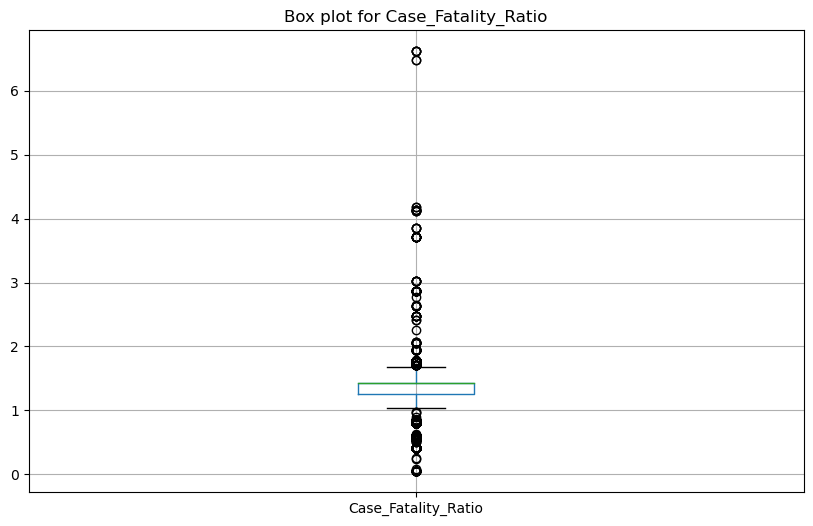

After outlier removal:


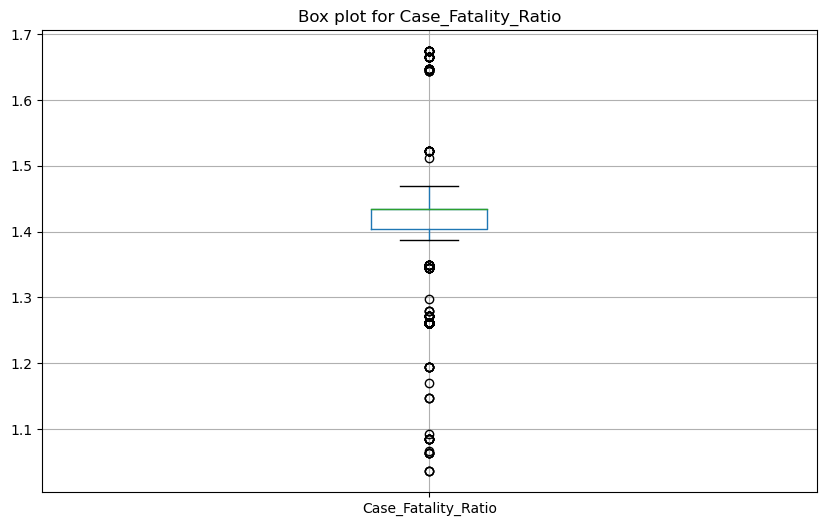

Original outcome distribution in training data:
 outcome_group
1    13241
2     2974
0      997
Name: count, dtype: int64
Resampled outcome distribution in training data:
 outcome_group
1    13241
2    13241
0    13241
Name: count, dtype: int64


In [99]:
column_names_to_check = ['Case_Fatality_Ratio'] 

# Visualizing outliers before removal
print("Before outlier removal:")
visualize_outliers(train_cases, column_names_to_check)

# Removing outliers
train_cases_no_outliers = reduce_outliers(train_cases, column_names_to_check, remove=True)
# Visualizing data after outlier removal
print("After outlier removal:")
visualize_outliers(train_cases_no_outliers, column_names_to_check)
''' We discover that removing the outliers make the prediction worst '''

# For train_cases
# Display original outcome distribution in the training set
train_cases_outcome = train_cases['outcome_group'].value_counts()
print("Original outcome distribution in training data:\n", train_cases_outcome)

# Separating features and target variable in the training dataset
X_train = train_cases.drop('outcome_group', axis=1)
y_train = train_cases['outcome_group']

# Applying SMOTE to balance the classes in the training dataset
# random_state can be change between 0~42 (doesn't matter)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

balanced_train_cases = pd.concat([X_train_resampled, y_train_resampled], axis=1)
print("Resampled outcome distribution in training data:\n", 
      balanced_train_cases['outcome_group'].value_counts())
train_cases = balanced_train_cases

## 6. Building Models and Hyperparameter Tuning

#### AUC-ROC Functions

In [100]:
# https://stackoverflow.com/questions/51378105/plot-multi-class-roc-curve-for-decisiontreeclassifier
# Credits to drew_psy 
# Calculating False Positive / True Positive rates
def calc_roc_auc(clf, x, y):
    y_proba = clf.predict_proba(x)
    y_bin = label_binarize(y, classes = [0, 1, 2])
    n_classes = y_bin.shape[1]
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc, n_classes
        
def plot_roc_model(clf, x, y):
    fpr, tpr, roc_auc, n_classes = calc_roc_auc(clf, x, y)
        
    colors = cycle(['blue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data')
    plt.legend(loc="lower right")
    plt.show()
    return 

#### Model Definitions

In [101]:
RANDOM_STATE = 42
TARGET_NAMES =['deceased', 'hospitalized', 'non_hospitalized']


def model_rf(x_train, x_test, y_train, y_test, params: dict, hyper_tuning: bool = False):
    if not hyper_tuning:
        clf = RandomForestClassifier(**params)
        clf.fit(x_train, y_train)
    
        train_preds = clf.predict(x_train)
        train_acc = accuracy_score(y_train, train_preds)
        y_preds = clf.predict(x_test)
        test_acc = accuracy_score(y_test, y_preds)
        
        rep = classification_report(y_test, y_preds, zero_division = 1, output_dict=True, target_names=TARGET_NAMES)
        results = {
            'hyperparameters': str(params),
            'mean_macro_f1': f"{rep['macro avg']['f1-score']: .2f}",
            'mean_deceased_f1': f"{rep['deceased']['f1-score']: .2f}",
            'mean_overall_accuracy': f"{test_acc: .2f}"
        }
    
        # plot_roc_model(clf, x_test, y_test)
        _, _, train_roc_auc, _ = calc_roc_auc(clf, x_train, y_train)
        _, _, test_roc_auc, _ = calc_roc_auc(clf, x_test, y_test)
        avg_train_auc = np.mean(list(train_roc_auc.values()))
        avg_test_auc = np.mean(list(test_roc_auc.values()))
        return train_acc, test_acc, rep, results, avg_train_auc, avg_test_auc
    else:
        clf = RandomForestClassifier()
        tuning = RandomizedSearchCV(clf, param_distributions=params, random_state=RANDOM_STATE, n_iter=50, cv=5, verbose=1, return_train_score=True)
        tuning.fit(x_train, y_train)
        results = pd.DataFrame(tuning.cv_results_)
        results.to_csv('./all_data/partB/model_results/%s.csv' % 'rf')
        
        train_preds = tuning.predict(x_train)
        train_acc = accuracy_score(y_train, train_preds)
        y_preds = tuning.predict(x_test)
        test_acc = accuracy_score(y_test, y_preds)
        rep = classification_report(y_test, y_preds, zero_division = 1, output_dict=True, target_names=TARGET_NAMES)
        # best_score: average cross-validated score
        return train_acc, test_acc, rep, tuning.best_score_, tuning.best_params_
    
    
def model_xgboost(x_train, x_test, y_train, y_test, params: dict, hyper_tuning: bool = False):
    if not hyper_tuning:
        clf = xgb.XGBClassifier(objective="multi:softprob", random_state=RANDOM_STATE, **params)      # for multi-class classification
        clf.fit(x_train, y_train)
    
        train_preds = clf.predict(x_train)
        train_acc = accuracy_score(y_train, train_preds)
        y_preds = clf.predict(x_test)
        test_acc = accuracy_score(y_test, y_preds)
        
        rep = classification_report(y_test, y_preds, zero_division = 1, output_dict=True, target_names=TARGET_NAMES)
        results = {
            'hyperparameters': str(params),
            'mean_macro_f1': f"{rep['macro avg']['f1-score']: .2f}",
            'mean_deceased_f1': f"{rep['deceased']['f1-score']: .2f}",
            'mean_overall_accuracy': f"{test_acc: .2f}"
        }
        
        return train_acc, test_acc, rep, results, y_preds
    else:
        clf = xgb.XGBClassifier(objective="multi:softprob", random_state=RANDOM_STATE)
        tuning = RandomizedSearchCV(clf, param_distributions=params, random_state=RANDOM_STATE, n_iter=50, cv=5, verbose=1, n_jobs=1, return_train_score=True, scoring='accuracy')
        tuning.fit(x_train, y_train)
        results = pd.DataFrame(tuning.cv_results_)
        results.to_csv('./all_data/partB/model_results/%s.csv' % 'xgb')
        
        train_preds = tuning.predict(x_train)
        train_acc = accuracy_score(y_train, train_preds)
        y_preds = tuning.predict(x_test)
        test_acc = accuracy_score(y_test, y_preds)
        rep = classification_report(y_test, y_preds, zero_division = 1, output_dict=True, target_names=TARGET_NAMES)
        return train_acc, test_acc, rep, tuning.best_score_, tuning.best_params_

def model_knn(x_train, x_test, y_train, y_test, params: dict, hyper_tuning: bool = False):
    
    if not hyper_tuning:
        clf = KNeighborsClassifier(**params)
        clf.fit(x_train, y_train)
    
        train_preds = clf.predict(x_train)
        train_acc = accuracy_score(y_train, train_preds)
        y_preds = clf.predict(x_test)
        test_acc = accuracy_score(y_test, y_preds)
        
        rep = classification_report(y_test, y_preds, zero_division = 1, output_dict=True, target_names=TARGET_NAMES)
        results = {
            'hyperparameters': str(params),
            'mean_macro_f1': f"{rep['macro avg']['f1-score']: .2f}",
            'mean_deceased_f1': f"{rep['deceased']['f1-score']: .2f}",
            'mean_overall_accuracy': f"{test_acc: .2f}"
        }
        return train_acc, test_acc, rep, results
    
    else:
        clf = KNeighborsClassifier()
        # tuning = RandomizedSearchCV(clf, param_distributions=params, random_state=RANDOM_STATE, 
                                    # n_iter=10, cv=5, verbose=2, n_jobs=1, return_train_score=True)
        tuning = GridSearchCV(clf, param_grid=params, refit=True, verbose=3, n_jobs=-1)   
        
        tuning.fit(x_train, y_train)
        results = pd.DataFrame(tuning.cv_results_)
        results.to_csv('./all_data/partB/model_results/%s.csv' % 'knn')
        
        train_preds = tuning.predict(x_train)
        train_acc = accuracy_score(y_train, train_preds)
        y_preds = tuning.predict(x_test)
        test_acc = accuracy_score(y_test, y_preds)
        rep = classification_report(y_test, y_preds, zero_division = 1, output_dict=True, target_names=TARGET_NAMES)
        # best_score: average cross-validated score
        return train_acc, test_acc, rep, tuning.best_score_, tuning.best_params_


#### Driver Code

In [102]:
X = train_cases.drop('outcome_group', axis=1).values
y = train_cases['outcome_group'].values

X_test_cases = test_cases.values

# Do a 80/20 train test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

##### Random Forest

In [115]:
# Smaller max_features reduces overfitting; sqrt is best for classification generally
# https://datascience.stackexchange.com/questions/66825/how-many-features-does-random-forest-need-for-the-trees
rf_params = {'n_estimators': 40, 'criterion': 'gini', 
             'min_samples_split': 2, 'min_samples_leaf': 1,  
             'max_features': 'sqrt', 'max_depth': 20,
             'random_state': RANDOM_STATE
             }
                
rf_params_tuning = {'n_estimators': range(20, 60), 
                    'criterion' : ['gini', 'entropy'],
                    'min_samples_split': [2,3,4,5], 
                    'min_samples_leaf': [1,2,3,4,5],  
                    'max_features': ['sqrt', 'log2'],
                    'max_depth': range(20, 26),
                    'random_state': [RANDOM_STATE]
                    }

print("\n1. Random Forest -- Without Scalers(): ")
train_acc, test_acc, rep, results, _, _ = model_rf(x_train, x_test, y_train, y_test, rf_params)
print('Random Forest Train Accuracy: %.2f' % train_acc)
print('Random Forest Test Accuracy: %.2f' % test_acc)
print('Report: \n', rep) 
print('Results: \n')
print('Hyperparamters: %s' % results['hyperparameters'])
print('Mean macro f1-score: %s' % results['mean_macro_f1'])
print('Mean deceased f1-score: %s' % results['mean_deceased_f1'])
print('Mean overall accuracy: %s' % results['mean_overall_accuracy'])

print("\n2. Without Scalers(), with Hyperparam tuning(): ")
train_acc, test_acc, rep, best_score, best_params = model_rf(x_train, x_test, y_train, y_test, rf_params_tuning, hyper_tuning=True)
print("Random Forest best params: ", best_params)
print('Random Forest Train Accuracy: %.2f' % train_acc)
print('Random Forest Test Accuracy: %.2f' % test_acc)
print('Random Forest Report: \n', rep) 


1. Random Forest -- Without Scalers(): 
Random Forest Train Accuracy: 0.99
Random Forest Test Accuracy: 0.95
Report: 
 {'deceased': {'precision': 0.9186530457813091, 'recall': 0.9256576439191765, 'f1-score': 0.9221420432966198, 'support': 2623.0}, 'hospitalized': {'precision': 0.9632925472747497, 'recall': 0.9752252252252253, 'f1-score': 0.9692221600447678, 'support': 2664.0}, 'non_hospitalized': {'precision': 0.9573896353166986, 'recall': 0.9382994732881866, 'f1-score': 0.9477484324529737, 'support': 2658.0}, 'accuracy': 0.946507237256136, 'macro avg': {'precision': 0.9464450761242524, 'recall': 0.946394114144196, 'f1-score': 0.9463708785981204, 'support': 7945.0}, 'weighted avg': {'precision': 0.9465802310504836, 'recall': 0.946507237256136, 'f1-score': 0.9464948706590685, 'support': 7945.0}}
Results: 

Hyperparamters: {'n_estimators': 40, 'criterion': 'gini', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'random_state': 42}
Mean macro f1-sc

##### XGBoost

In [104]:
xgb_params = {"colsample_bytree": 0.89,              
              "gamma": 0.07,                           
              "learning_rate": 0.12,                
              "max_depth": 9,                         
              "n_estimators": 370,                  
              "subsample": 0.78,
              }
# For a good general understanding on main params for XGBoost: 
# https://medium.com/@rithpansanga/the-main-parameters-in-xgboost-and-their-effects-on-model-performance-4f9833cac7c
xgb_params_tuning = {
                     "colsample_bytree": np.linspace(0.5, 1, 100, endpoint=True), # controls fraction of features used for each tree. 
                                                                             #smaller -> smaller and less complex models (prevents overfitting) common=[0.5, 1]
                     "gamma": np.linspace(0, 0.1, 100, endpoint=True),
                     "learning_rate": np.linspace(0.05, 0.3, 100, endpoint=True), # smaller -> slower but more accurate, default=0.3  
                     "max_depth": randint(2, 10),                         # smaller -> simplier model (underfitting), larger -> overfitting. default=6
                     "n_estimators": randint(100, 500),                  # number of trees. larger --> overfitting. default 100. common=[100, 1000]
                     "subsample": np.linspace(0.7, 1, 100, endpoint=True)
                     }

print("\n1. XGBoost -- Without Scalers(): ")
train_acc, test_acc, rep, results, y_preds = model_xgboost(x_train, x_test, y_train, y_test, xgb_params)
print('XGBoost Train Accuracy: %.2f' % train_acc)
print('XGBoost Test Accuracy: %.2f' % test_acc)
print('XGBoost Report: \n', rep) 
print('Results: \n')
print('Hyperparamters: %s' % results['hyperparameters'])
print('Mean macro f1-score: %s' % results['mean_macro_f1'])
print('Mean deceased f1-score: %s' % results['mean_deceased_f1'])
print('Mean overall accuracy: %s' % results['mean_overall_accuracy'])

print("\n2. Without Scalers(), with Hyperparam tuning(): ")
train_acc, test_acc, rep, best_score, best_params = model_xgboost(x_train, x_test, y_train, y_test, xgb_params_tuning, hyper_tuning=True)
print("XGBoost best params: ", best_params)
print("XGBoost best score: ", best_score)
print('XGBoost Train Accuracy: %.2f' % train_acc)
print('XGBoost Test Accuracy: %.2f' % test_acc)
print('XGBoost Report: \n', rep) 


1. XGBoost -- Without Scalers(): 
XGBoost Train Accuracy: 0.99
XGBoost Test Accuracy: 0.95
XGBoost Report: 
 {'deceased': {'precision': 0.93111279333838, 'recall': 0.9378574151734655, 'f1-score': 0.9344729344729346, 'support': 2623.0}, 'hospitalized': {'precision': 0.970193740685544, 'recall': 0.9774774774774775, 'f1-score': 0.9738219895287958, 'support': 2664.0}, 'non_hospitalized': {'precision': 0.9629629629629629, 'recall': 0.9488337095560572, 'f1-score': 0.9558461246920599, 'support': 2658.0}, 'accuracy': 0.9548143486469478, 'macro avg': {'precision': 0.954756498995629, 'recall': 0.9547228674023334, 'f1-score': 0.9547136828979301, 'support': 7945.0}, 'weighted avg': {'precision': 0.9548723143698447, 'recall': 0.9548143486469478, 'f1-score': 0.9548172796297942, 'support': 7945.0}}
Results: 

Hyperparamters: {'colsample_bytree': 0.89, 'gamma': 0.07, 'learning_rate': 0.12, 'max_depth': 9, 'n_estimators': 370, 'subsample': 0.78}
Mean macro f1-score:  0.95
Mean deceased f1-score:  0.93

##### K-Nearest Neighbours

In [106]:
knn_params = {'n_neighbors': 4, 
              'weights' : 'distance', # Distance is is a lot more strict
              'algorithm': 'kd_tree', 
              'leaf_size': 25,  
              'p': 1, # p = 1: manhattan_distance (l1), p = 2: euclidean_distance (l2)
              'n_jobs': -1, # use all your cpu cores
              }

knn_params_tuning = {'n_neighbors': range(3, 10), 
                     'weights' :['uniform', 'distance'], # Distance is is a lot more strict
                     'algorithm': ['kd_tree', 'ball_tree'], # brute force is worse in every aspect
                     'leaf_size': [25],  # Has no effect on the model, only on the speed of execution
                     'p': [1, 2],
                     'n_jobs': [-1],
                     }

print("\n1. KNN -- Without Scalers(): ")   
train_acc, test_acc, rep, results = model_knn(x_train, x_test, y_train, y_test, knn_params)
print('K-Nearest Train Accuracy: %.2f' % train_acc)
print('K-Nearest Test Accuracy: %.2f' % test_acc)
print('Report: \n', rep) 
print('Results: \n')
print('Hyperparamters: %s' % results['hyperparameters'])
print('Mean macro f1-score: %s' % results['mean_macro_f1'])
print('Mean deceased f1-score: %s' % results['mean_deceased_f1'])
print('Mean overall accuracy: %s' % results['mean_overall_accuracy'])

print("\n2. Without Scalers(), with Hyperparam tuning(): ")
train_acc, test_acc, rep, best_score, best_params = model_knn(x_train, x_test, y_train, y_test, knn_params_tuning, hyper_tuning=True)
print("K-Nearest best params: ", best_params)
print("K-Nearest best score: ", best_score)
print('K-Nearest Train Accuracy: %.2f' % train_acc)
print('K-Nearest Test Accuracy: %.2f' % test_acc)
print('K-Nearest Report: \n', rep) 


1. KNN -- Without Scalers(): 
K-Nearest Train Accuracy: 0.99
K-Nearest Test Accuracy: 0.94
Report: 
 {'deceased': {'precision': 0.9013878743608473, 'recall': 0.9409073579870377, 'f1-score': 0.9207237455698564, 'support': 2623.0}, 'hospitalized': {'precision': 0.9739096573208723, 'recall': 0.9388138138138138, 'f1-score': 0.956039755351682, 'support': 2664.0}, 'non_hospitalized': {'precision': 0.9594543387646836, 'recall': 0.9525959367945824, 'f1-score': 0.9560128374551634, 'support': 2658.0}, 'accuracy': 0.944115796098175, 'macro avg': {'precision': 0.9449172901488011, 'recall': 0.9441057028651446, 'f1-score': 0.9442587794589006, 'support': 7945.0}, 'weighted avg': {'precision': 0.9451309444918609, 'recall': 0.944115796098175, 'f1-score': 0.9443713549203824, 'support': 7945.0}}
Results: 

Hyperparamters: {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 25, 'p': 1, 'n_jobs': -1}
Mean macro f1-score:  0.94
Mean deceased f1-score:  0.92
Mean overall accuracy:

## 7. Overfitting


#### Random Forest AUC-ROC Plotting

In [111]:
def tune_hparam_auc_acc(model, x_train, x_test, y_train, y_test, values, params, param: str):
    train_results = []
    test_results = []
    train_accuracies = []
    test_accuracies = []
    
    for value in values:
        params[param] = value
        train_acc, test_acc, _, _, avg_train_auc, avg_test_auc = model(x_train, x_test, y_train, y_test, params)
        train_results.append(avg_train_auc)
        test_results.append(avg_test_auc)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
   
    values = ['None' if v is None else v for v in values]
    plt.figure()
    line1, = plt.plot(values, train_results, 'b', label="Train AUC")
    line2, = plt.plot(values, test_results, 'r', label="Test AUC")
    line3, = plt.plot(values, train_accuracies, 'g', label="Train Acc")
    line4, = plt.plot(values, test_accuracies, 'y', label="Test Acc")
    
    plt.legend(handler_map = {line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC/Acc score')
    plt.xlabel(param)
    plt.title('Different Values of ' + param + ' on Accuracy and AUC')
    plt.show()
    
def plot_auc_rf_tuning(rfmodel, x_train, x_test, y_train, y_test):
    n_estimators = [1, 2, 4, 8, 16, 32, 64, 128] # >40 is good
    tune_hparam_auc_acc(model_rf, x_train, x_test, y_train, y_test,
                     n_estimators, {'random_state': RANDOM_STATE}, 'n_estimators')
    max_depths = range(1, 32) # >20 is good
    tune_hparam_auc_acc(model_rf, x_train, x_test, y_train, y_test,
                     max_depths, {'n_estimators': 40, 'random_state': RANDOM_STATE}, 'max_depth')
    max_features = ['sqrt', 'log2', len(x_train[0]), None] # sqrt is best
    tune_hparam_auc_acc(model_rf, x_train, x_test, y_train, y_test,
                     max_features, {'n_estimators': 40, 'random_state': RANDOM_STATE}, 'max_features')
    # 1% to 50% of total data
    min_samples_splits = np.linspace(0.01, 0.5, 50, endpoint=True) # Lower is better (Only raise if not enough time/resources)
    tune_hparam_auc_acc(model_rf, x_train, x_test, y_train, y_test,
                     min_samples_splits, {'n_estimators': 40, 'random_state': RANDOM_STATE}, 'min_samples_split')
    # 1% to 50% of total data
    min_samples_leafs = np.linspace(0.01, 0.5, 50, endpoint=True) # Lower is better (Only raise if not enough time/resources)
    tune_hparam_auc_acc(model_rf, x_train, x_test, y_train, y_test,
                     min_samples_leafs, {'n_estimators': 40, 'random_state': RANDOM_STATE}, 'min_samples_leaf')
    criterions = ['gini', 'entropy', 'log_loss'] # Gini is best
    tune_hparam_auc_acc(model_rf, x_train, x_test, y_train, y_test,
                     criterions, {'n_estimators': 40, 'random_state': RANDOM_STATE}, 'criterion')
    return


#### Validation Curve Plotting

In [109]:

def plot_knn_k_tuning(X, y):
    
    param_range = range(1, 11)
    # Calculate accuracy on training and test set using the
    # gamma parameter with 5-fold cross validation
    train_score, test_score = validation_curve(KNeighborsClassifier(), X, y, param_name = "n_neighbors",
                                               param_range = param_range, cv = 5, scoring = "accuracy")
    plt.figure()
    line1, = plt.plot(param_range, np.mean(train_score, axis = 1), 'r', label = "Train Accuracy")
    line2, = plt.plot(param_range, np.mean(test_score, axis = 1), 'b', label = "Cross Validation (Test) Accuracy")
    plt.legend(handler_map = {line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('Accuracy')
    plt.xlabel('K Value')
    plt.title('Validation Curve of KNN Classifier')
    plt.show()
    
def plot_rf_estimators_tuning(X, y):
    
    param_range = range(0, 120, 20)
    # Calculate accuracy on training and test set using the
    # gamma parameter with 5-fold cross validation
    train_score, test_score = validation_curve(RandomForestClassifier(), X, y, param_name = "n_estimators",
                                               param_range = param_range, cv = 5, scoring = "accuracy")
    plt.figure()
    line1, = plt.plot(param_range, np.mean(train_score, axis = 1), 'r', label = "Train Accuracy")
    line2, = plt.plot(param_range, np.mean(test_score, axis = 1), 'b', label = "Cross Validation (Test) Accuracy")
    plt.legend(handler_map = {line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('Accuracy')
    plt.xlabel('n_estimators')
    plt.title('Validation Curve of RF Classifier')
    plt.show()

def plot_XGB_depth_tuning(X, y):
    
    param_range = range(1, 16)
    # Calculate accuracy on training and test set using the
    # gamma parameter with 5-fold cross validation
    train_score, test_score = validation_curve(xgb.XGBClassifier(objective="multi:softprob", random_state=RANDOM_STATE),
                                               X, y, param_name = "max_depth",
                                               param_range = param_range, cv = 5, scoring = "accuracy")
    plt.figure()
    line1, = plt.plot(param_range, np.mean(train_score, axis = 1), 'r', label = "Train Accuracy")
    line2, = plt.plot(param_range, np.mean(test_score, axis = 1), 'b', label = "Cross Validation (Test) Accuracy")
    plt.legend(handler_map = {line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('Accuracy')
    plt.xlabel('max_depth')
    plt.title('Validation Curve of XGBoost Classifier')
    plt.show()
    
def plot_XGB_estimators_tuning(X, y):
    
    param_range = range(100, 900, 100)
    # Calculate accuracy on training and test set using the
    # gamma parameter with 5-fold cross validation
    train_score, test_score = validation_curve(xgb.XGBClassifier
                                               (objective="multi:softprob", random_state=RANDOM_STATE, colsample_bytree = 0.1),
                                               X, y, param_name = "n_estimators",
                                               param_range = param_range, cv = 5, scoring = "accuracy")
    plt.figure()
    line1, = plt.plot(param_range, np.mean(train_score, axis = 1), 'r', label = "Train Accuracy")
    line2, = plt.plot(param_range, np.mean(test_score, axis = 1), 'b', label = "Cross Validation (Test) Accuracy")
    plt.legend(handler_map = {line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('Accuracy')
    plt.xlabel('n_estimators')
    plt.title('Validation Curve of XGBoost Classifier')
    plt.show()

#### Driver Code

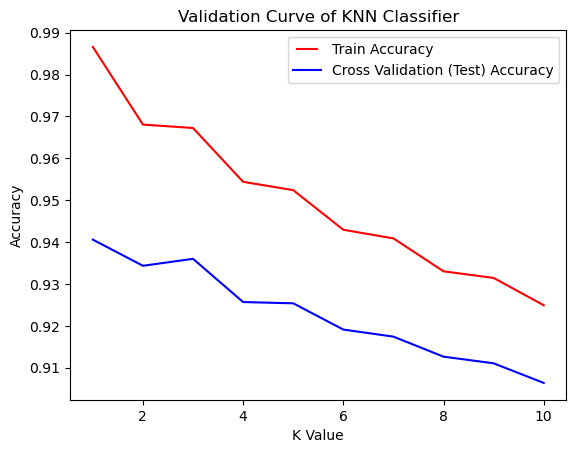

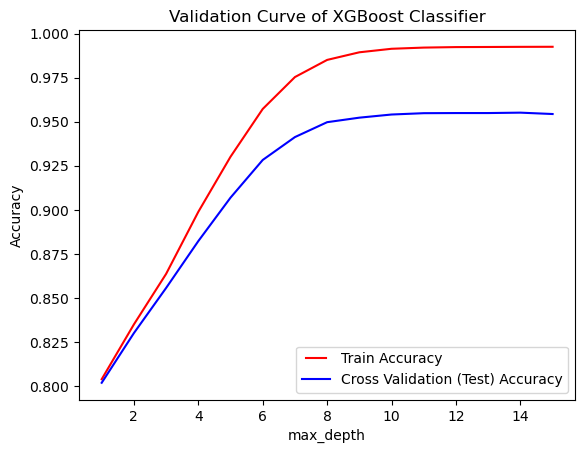

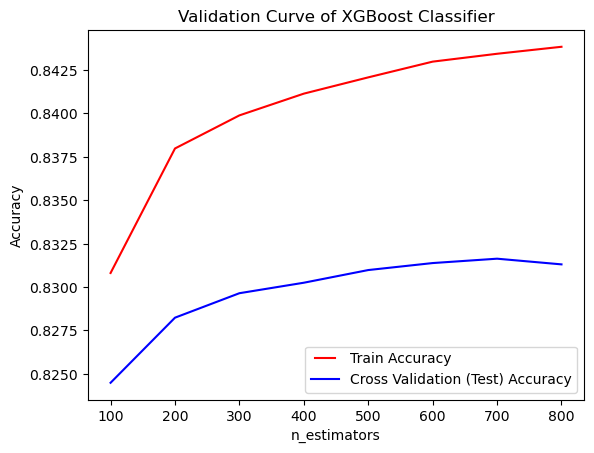

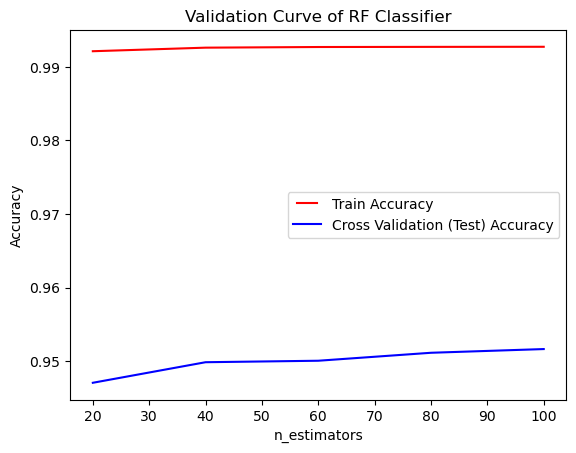

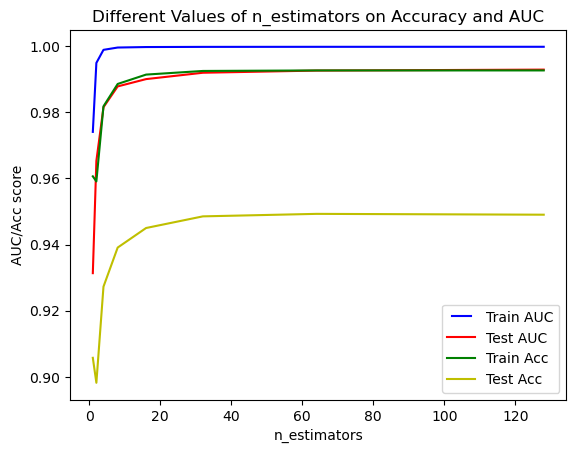

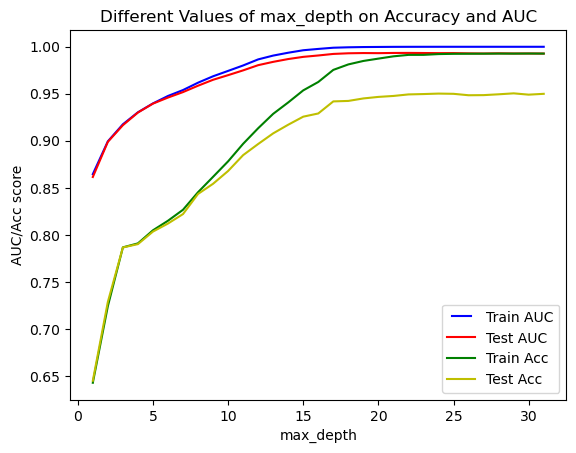

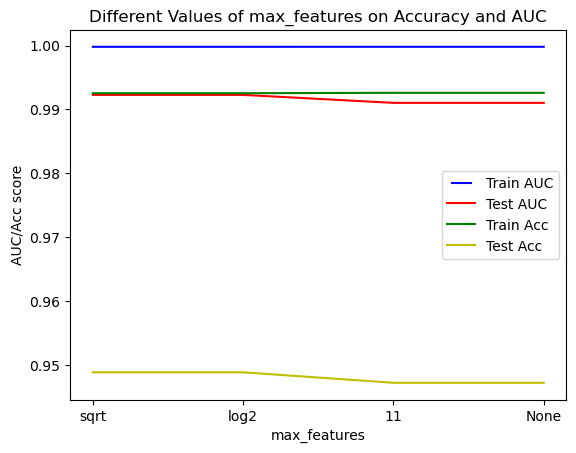

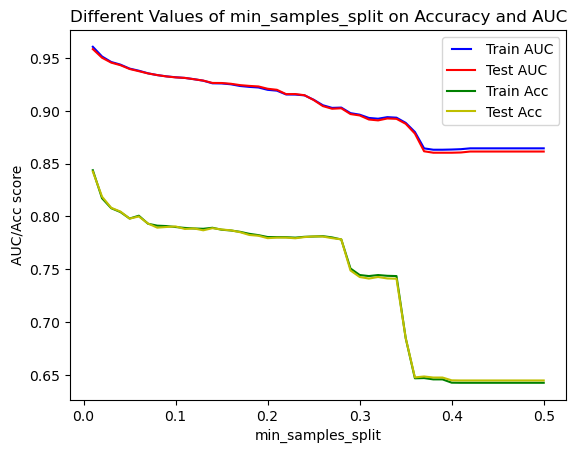

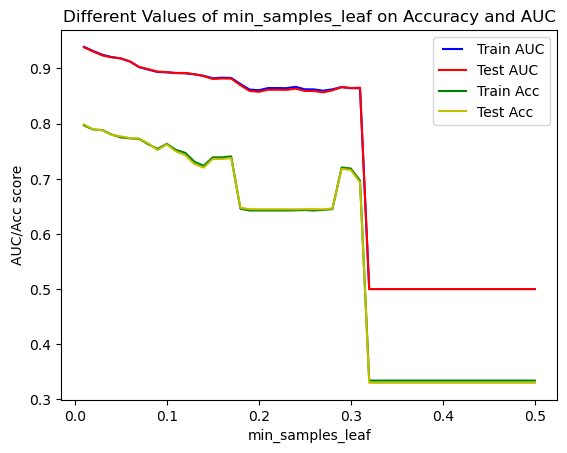

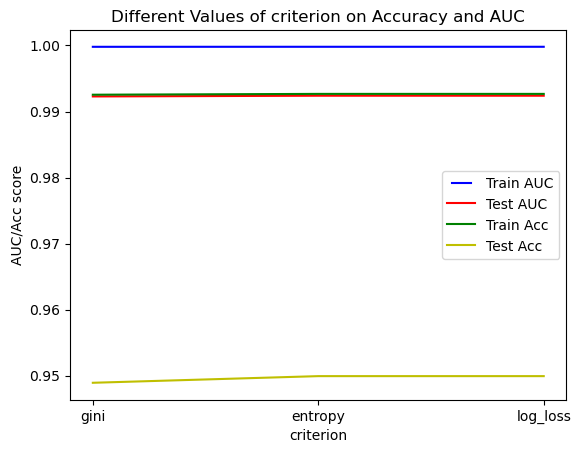

In [112]:
plot_knn_k_tuning(X, y)
plot_XGB_depth_tuning(X, y)
plot_XGB_estimators_tuning(X, y)
plot_rf_estimators_tuning(X, y)
plot_auc_rf_tuning(model_rf, x_train, x_test, y_train, y_test)

## 9. Prediction on the Test Set

#### Results

In [113]:
'''For labelling test data without predictions of the outcome_group'''
def create_submission_file(y_preds, file_name):
    with open(file_name, "w") as csvfile:
        wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
        wr.writerow(["Id", "Prediction"])
        for i, pred in enumerate(y_preds):
            wr.writerow([str(i), str(pred)])
    return

In [114]:
clf = xgb.XGBClassifier(objective="multi:softprob", random_state=RANDOM_STATE, **xgb_params)      # for multi-class classification
clf.fit(x_train, y_train)
predictions = clf.predict(X_test_cases)
create_submission_file(y_preds=predictions, file_name="submission_%s.csv" % "xgb")

clf = RandomForestClassifier(**rf_params)      # for multi-class classification
clf.fit(x_train, y_train)
predictions = clf.predict(X_test_cases)
create_submission_file(y_preds=predictions, file_name="submission_%s.csv" % "rf")

clf = KNeighborsClassifier(**knn_params)      # for multi-class classification
clf.fit(x_train, y_train)
predictions = clf.predict(X_test_cases)
create_submission_file(y_preds=predictions, file_name="submission_%s.csv" % "knn")